I'm working on porting the proof of concept in the other notebooks into a speedy PyTorch implementation.

At the crux of this is the assumption (that as far as I can tell is true) that a 4D wavelet transform can be built from 2 2D wavelet transforms on 2 sets of axes. Part of this will be to test that. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pytorch_wavelets import DWTForward

import numpy as np
from scipy import ndimage
import pandas as pd
from glob import glob
from os import path

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/3
class GaussianFilter(nn.Module):
    def __init__(self, n1, n2, l = 1):
        
        super(GaussianFilter, self).__init__()

        self.n1, self.n2, self.l = n1, n2, l
        kernel_size = 10
        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        x_cord = torch.arange(kernel_size)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1).type(torch.get_default_dtype())

        mean = (kernel_size - 1)/2.
        variance = l**2.

        # Calculate the 2-dimensional gaussian kernel which is
        # the product of two gaussian distributions for two different
        # variables (in thigaussian_kernel = (1./(2.*math.pi*variance)) *\
        gaussian_kernel = (1./(2.*np.pi*l)) *\
                            torch.exp(
                              -torch.sum((xy_grid - mean)**2., dim=-1) /\
                              (2*l)
                          )
            
        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

        # Reshape to 2d depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(n1, 1 ,1, 1)
        

        self.gaussian_filter = nn.Conv2d(in_channels=n1, out_channels=n1,
                                    kernel_size=n2, groups=n1, bias=False, padding=(kernel_size/2))

        self.gaussian_filter.weight.data = gaussian_kernel
        self.gaussian_filter.weight.requires_grad = False
        
    def forward(self, x):
        #print x.shape, self.n1, self.n2
        assert x.shape[0] == x.shape[1] and x.shape[0] == self.n1
        assert x.shape[2] == x.shape[3] and x.shape[2] == self.n2
        
        out = self.gaussian_filter(x)
        
        return out[:,:, :-1, :-1] # slice off some of the padding :( )

In [13]:
class WaveNet(nn.Module):
    def __init__(self, n_pos, n_vel, sigmas= [1.0, 5.0, 10.0], wavelets = ['bior1.1', 'bior2.2', 'bior3.3']): # TODO customize size and features
        super(WaveNet, self).__init__()
        
        self.n_pos = n_pos
        self.n_vel = n_vel

        self.sigmas = sigmas
        self.wavelets = wavelets
        
        self.gauss_filters, self.wavelet_filters ={}, {}
        
        for s in sigmas:
            gauss_filter1 = GaussianFilter(n_pos, n_vel, s)
            gauss_filter2 = GaussianFilter(n_vel, n_pos, s)
            self.gauss_filters[s] = (gauss_filter1, gauss_filter2)
        
        #self.gauss_filter = lambda im : torch.Tensor(ndimage.filters.gaussian_filter(im, 1) )

        for w in wavelets:
        
            wavelet = DWTForward(J=1, wave = w)
            self.wavelet_filters[w] = wavelet
        
        
        self.upsample1 = F.interpolate(size = (n_pos, n_pos))
        self.upsample2 = F.interpolate(size = (n_vel, n_vel))
        #model.cuda()?
        
    def forward(self, x):
        assert x.shape[0] == x.shape[1] and x.shape[0] == self.n_pos
        assert x.shape[2] == x.shape[3] and x.shape[2] == self.n_vel
        
        # Gaussian smoothing
        
        smooth_outs = []
        
        for s, (g1, g2) in self.gauss_filters.iteritems():
            o = g1(x)
            o = o.permute(2,3,0,1)
            #print x.shape
            o = g2(o)
            smooth_outs.append(o.permute(2,3,0,1) )

        out = torch.Tensor(np.zeros((n_pos, n_pos, n_vel, n_vel)) )
        
        for w, (wv) in self.wavelet_filters.iteritems():
            for so in smooth_outs:
                o,_ = wv(so)
                o = o.permute(2,3,0,1)
                o, _ = wv(o)
                
                o = self.upsample2(o)
                o = o.permute(2,3,0,1)
                o = self.upsample1(o)
                
                out+=o
                
        
        return out

In [14]:
data_dir = 'gaia_data/' #unzipped "v2" 

In [15]:
dwarfs = sorted(glob(path.join(data_dir, '*dwarf.txt')))
rests = sorted(glob(path.join(data_dir, '*rest.txt')))

In [16]:
def make_field_image(full_field, n_pos= 101, n_vel=101):
    pos_min, pos_max =  np.min(full_field, axis =0)[:2], np.max(full_field, axis =0)[:2]
    ra_min, ra_max = pos_min[0]-0.1, pos_max[0]+0.1
    dec_min, dec_max = pos_min[1]-0.1, pos_max[1]+0.1

    vra_min, vra_max = -20, 20
    vdec_min, vdec_max =-20, 20

    field_image, _ = np.histogramdd(full_field,\
                            bins=(np.linspace(ra_min, ra_max, n_pos),
                                  np.linspace(dec_min, dec_max, n_pos), 
                                  np.linspace(vra_min, vra_max, n_vel),
                                  np.linspace(vdec_min, vdec_max, n_vel) ) )
    
    return field_image

In [17]:
d_fname = dwarfs[5]
r_fname = rests[5]
d_data = pd.read_csv(d_fname)
r_data = pd.read_csv(r_fname)

d_field = np.c_[d_data['ra'].as_matrix(), d_data['dec'].as_matrix(), d_data['pmra'].as_matrix(), d_data['pmdec'].as_matrix()]
r_field = np.c_[r_data['ra'].as_matrix(), r_data['dec'].as_matrix(), r_data['pmra'].as_matrix(), r_data['pmdec'].as_matrix()]
full_field = np.vstack([d_field, r_field])
full_field = full_field[np.all(~np.isnan(full_field), axis = 1)]

n_pos, n_vel = 100, 100 
field_image = make_field_image(full_field, n_pos+1, n_vel+1)

In [18]:
def plot(im): #, orig_field):
    #max_pos = ndimage.measurements.maximum_position(np.abs(im))
    plt.subplot(121)
    plt.imshow(im.sum(axis = (2,3)).T)
    #plt.scatter(max_pos[0], max_pos[1], marker = 'x')
    plt.subplot(122)
    plt.imshow(im.sum(axis = (0,1)).T)
    #plt.scatter(max_pos[2], max_pos[3], marker = 'x')

    plt.show()

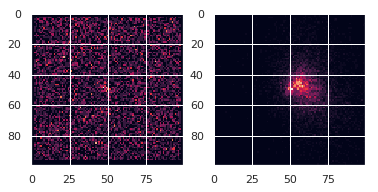

In [19]:
plot(field_image)

In [27]:
wv = WaveNet(n_pos, n_vel, sigmas = [1.0, 2.0], wavelets = ['bior1.1', 'bior2.2'])

In [28]:
out = wv(torch.Tensor(field_image))

/share/software/user/open/py-pytorch/1.0.0_py27/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/share/software/user/open/py-pytorch/1.0.0_py27/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/share/software/user/open/py-pytorch/1.0.0_py27/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/share/software/user/open/py-pytorch/1.0.0_py27/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample

In [29]:
out.shape

torch.Size([100, 100, 100, 100])

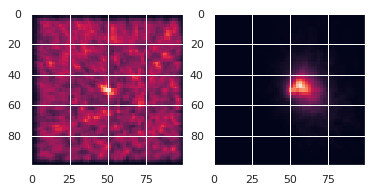

In [30]:
plot(out.numpy())